In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import pandas as pd
from glob import glob
import random
import matplotlib.cm as cm
from input.init import model
from input.visualization import extract_min_max_price_metric, replace_nans_and_zeros,_create_heatmap_gamma_only,create_comparative_heatmaps_gl,extract_metric_data_gl

In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_gamma_dependence_gl(
    results_dir,
    experiment_name="*",
    metric_name="Profit Gain",
    price_plot='none',
    figsize=(8, 6)
):
    """
    Traverses the same gamma_x_lambda_y directories, extracts your chosen metric,
    then for each gamma averages over all lambdas (and computes std), and finally
    calls _create_heatmap_gamma_only to plot metric vs gamma.

    Parameters
    ----------
    results_dir : str
        Base directory containing experiment subdirectories.
    experiment_name : str
        Pattern to match specific experiment folder(s).
    metric_name : str
        Which metric to extract (e.g. "Profit Gain", or "Price").
    price_plot : {'none','min','max'}
        If metric_name == "Price", choose whether to plot min or max price.
    figsize : tuple
        Passed on to the plotting helper.
    """

    # resolve and find all runs
    results_dir = os.path.abspath(results_dir)
    exp_dir = os.path.join(results_dir, experiment_name)
    pattern = "gamma_*_lambda_*"
    run_dirs = glob(os.path.join(exp_dir, pattern))
    if not run_dirs:
        raise ValueError(f"No run directories matching {pattern} in {exp_dir}")

    γ_vals, λ_vals = [], []
    metric_vals, min_prices, max_prices = [], [], []

    for run_dir in run_dirs:
        basename = os.path.basename(run_dir)
        try:
            γ = float(basename.split('gamma_')[1].split('_lambda_')[0])
            λ = float(basename.split('lambda_')[1].split('_')[0])
        except Exception:
            # skip malformed names
            continue

        stats_file = os.path.join(run_dir, "cycle_statistics.csv")
        if not os.path.exists(stats_file):
            continue

        df = pd.read_csv(stats_file)
        # pick correct metric columns
        if metric_name == 'mean_cycle_length':
            cols = [c for c in df.columns if c.startswith('mean_cycle_length')]
        else:
            key = metric_name.lower().replace(" ", "_")
            cols = [c for c in df.columns if c.startswith(f"mean_{key}_p")]

        if not cols:
            continue

        val = df[cols].mean(axis=1).iloc[0]
        γ_vals.append(γ)
        λ_vals.append(λ)
        metric_vals.append(val)

        # price extremes
        mn, mx = extract_min_max_price_metric(run_dir)
        min_prices.append(mn)
        max_prices.append(mx)

    if not γ_vals:
        raise ValueError("No valid data to process.")

    # If user asked for Price-min or Price-max, override metric_vals
    if metric_name == "Price" and price_plot in ('min','max'):
        metric_name = f"Price {'Min' if price_plot=='min' else 'Max'}"
        metric_vals = min_prices if price_plot=='min' else max_prices

    # Build a DataFrame and group by gamma
    df = pd.DataFrame({
        'gamma': γ_vals,
        'lambda': λ_vals,
        'value': metric_vals
    })
    grouped = df.groupby('gamma')['value'].agg(['mean','std']).reset_index()

    # now plot γ vs mean( value ) ± std
    fig = _create_heatmap_gamma_only(
        gamma_values=grouped['gamma'].tolist(),
        data_means=grouped['mean'].tolist(),
        data_stds=grouped['std'].tolist(),
        metric_name=metric_name,
        figsize=figsize
    )
    return fig


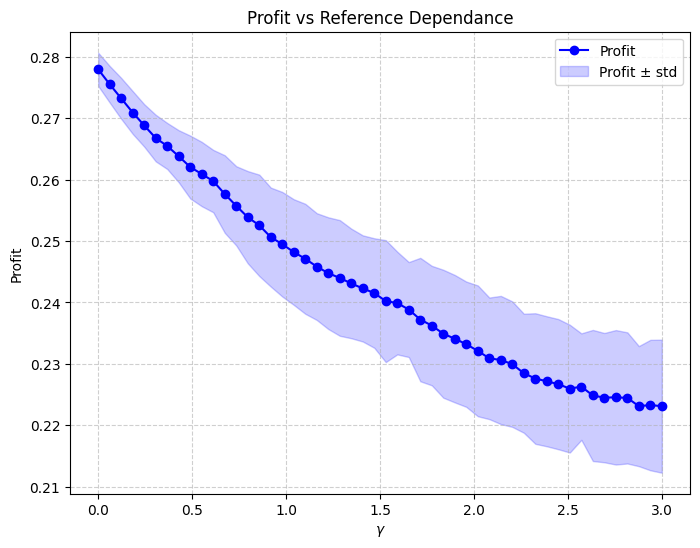

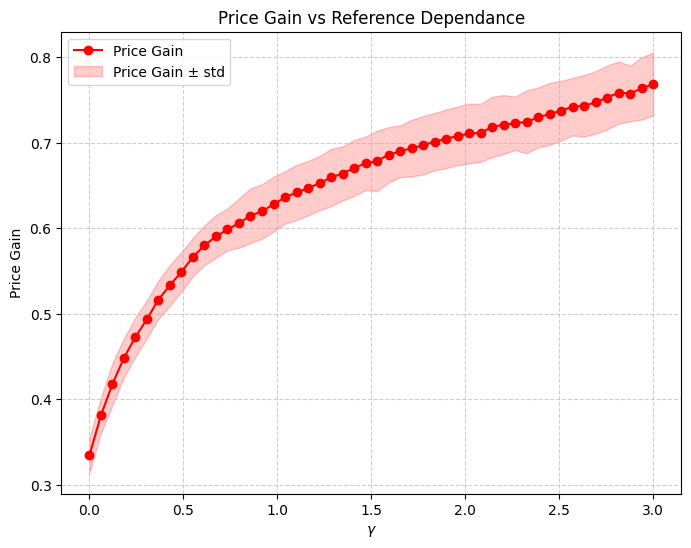

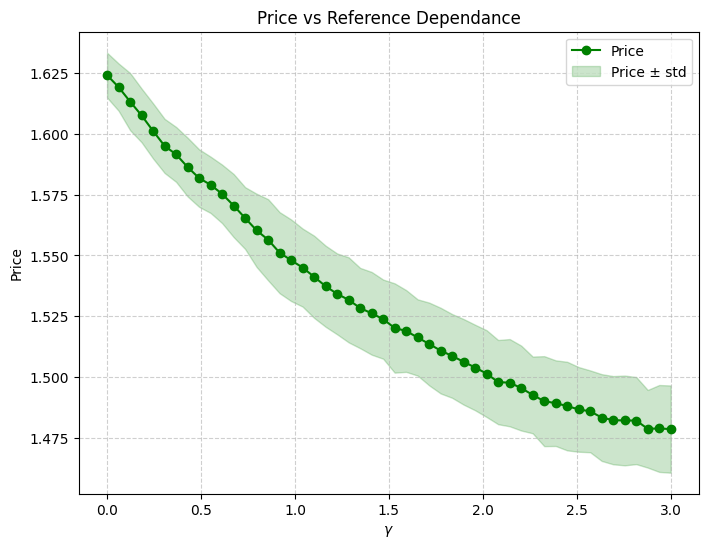

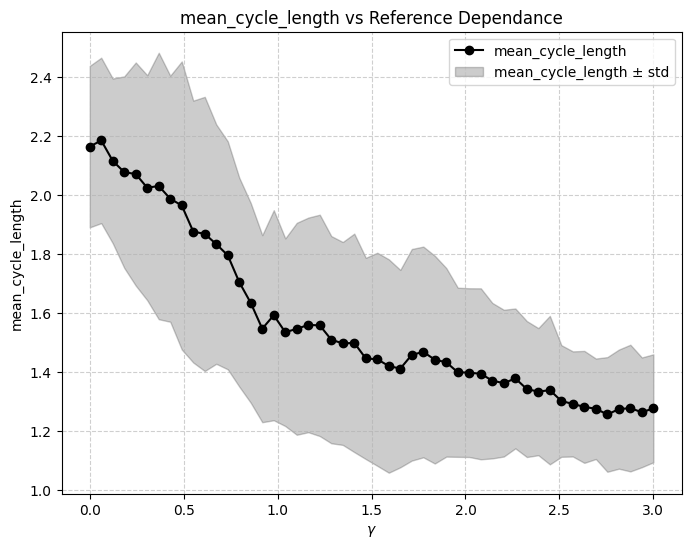

In [3]:
folder_location = "../Results_sockeye/experiments"
experiment_name =  "reference_impact_misspecification/gamma_lambda" + "_" + "reference"
fig_profit = create_gamma_dependence_gl(folder_location,  experiment_name=experiment_name, metric_name="Profit")
fig_price_gain = create_gamma_dependence_gl(folder_location, experiment_name=experiment_name, metric_name="Price Gain")
#fig_profit_gain = create_gamma_dependence_gl(folder_location, experiment_name=experiment_name, metric_name="Profit Gain")
fig_price = create_gamma_dependence_gl(folder_location, experiment_name=experiment_name, metric_name="Price")
fig_cycle = create_gamma_dependence_gl(folder_location, experiment_name=experiment_name, metric_name="mean_cycle_length")
#fig_price_min = create_gamma_dependence_gl(folder_location, experiment_name=experiment_name, metric_name="Price", price_plot = 'min')
#fig_price_max = create_gamma_dependence_gl(folder_location, experiment_name=experiment_name, metric_name="Price", price_plot = 'max')
# # Create "Figures" directory
figures_dir = os.path.join(folder_location, experiment_name, "Generated_Figures")
os.makedirs(figures_dir, exist_ok=True)

# Save figures
fig_profit.savefig(os.path.join(figures_dir, "profit_heatmap.png"))
fig_price_gain.savefig(os.path.join(figures_dir, "price_gain_heatmap.png"))
fig_price.savefig(os.path.join(figures_dir, "price_heatmap.png"))
fig_cycle.savefig(os.path.join(figures_dir, "cyclelength_heatmap.png"))
# fig_price_min.savefig(os.path.join(figures_dir, "price_min_heatmap.png"))
# fig_price_max.savefig(os.path.join(figures_dir, "price_max_heatmap.png"))

***
Generating common referece True vs False comparison figures

../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Re

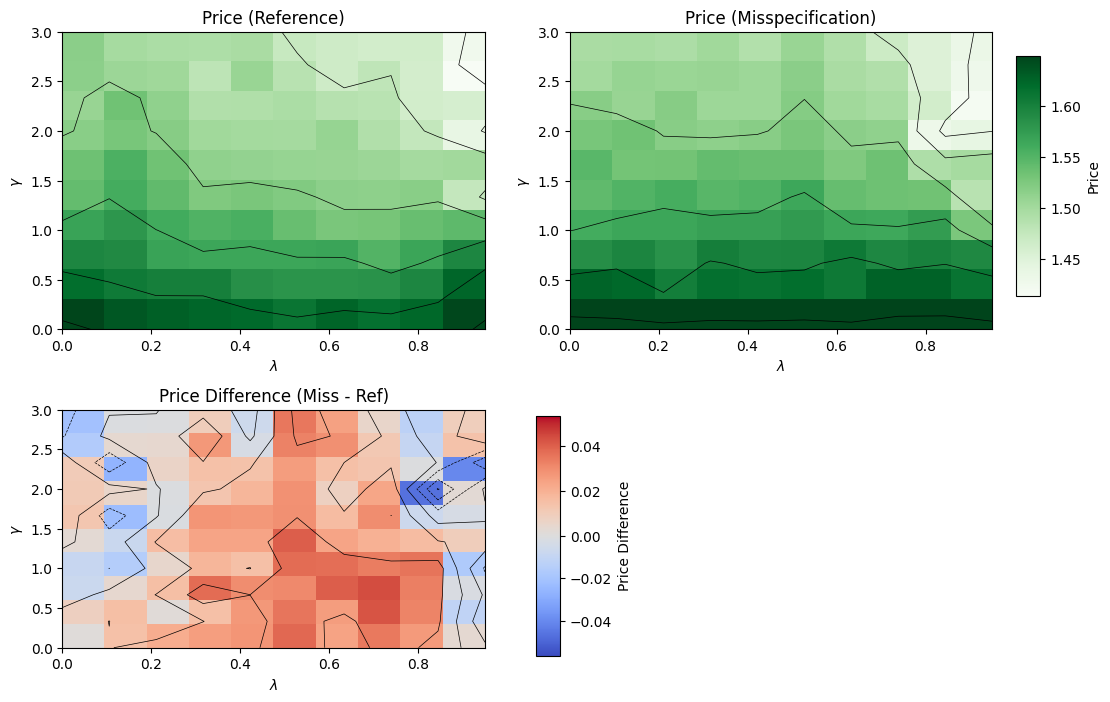

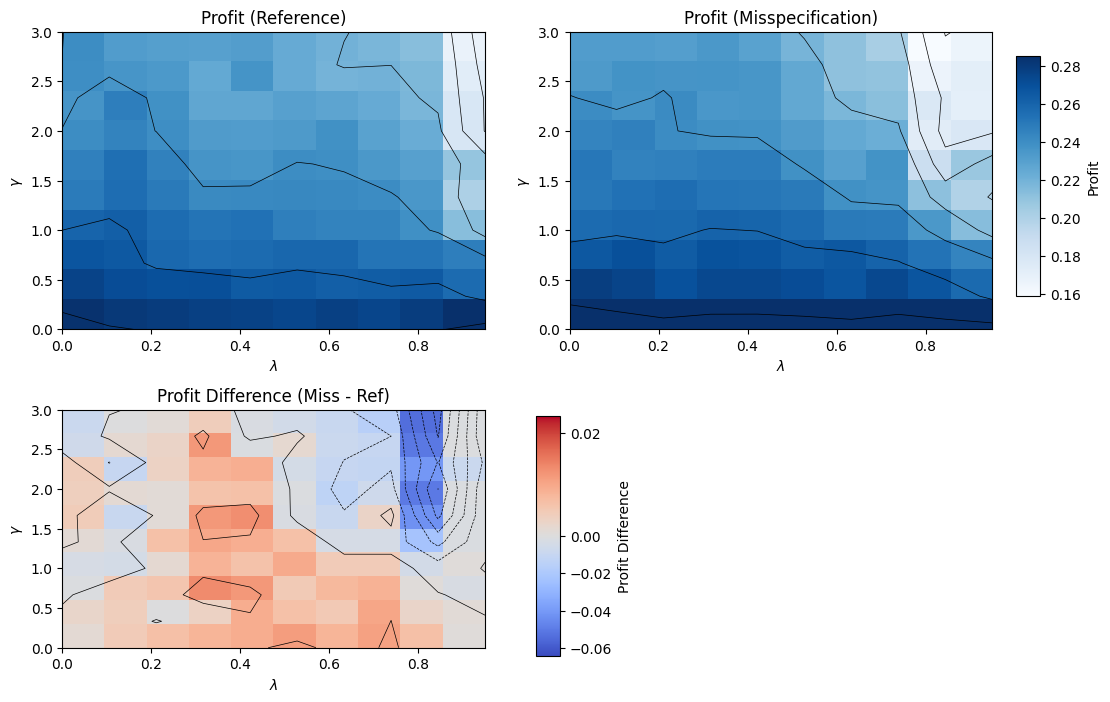

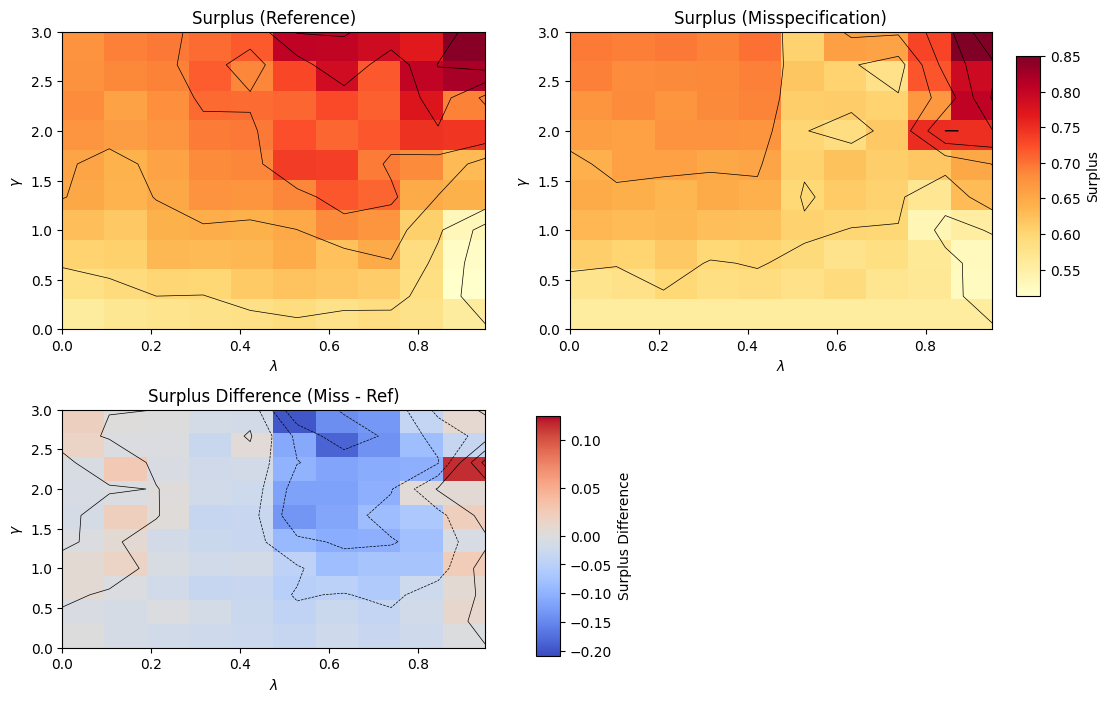

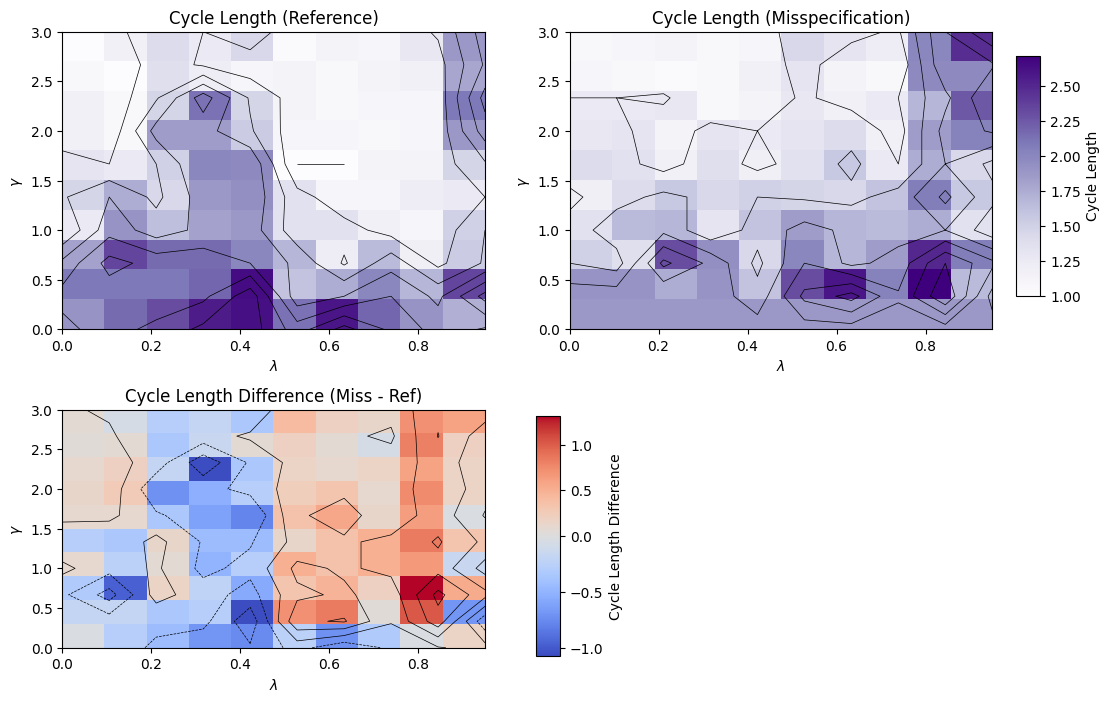

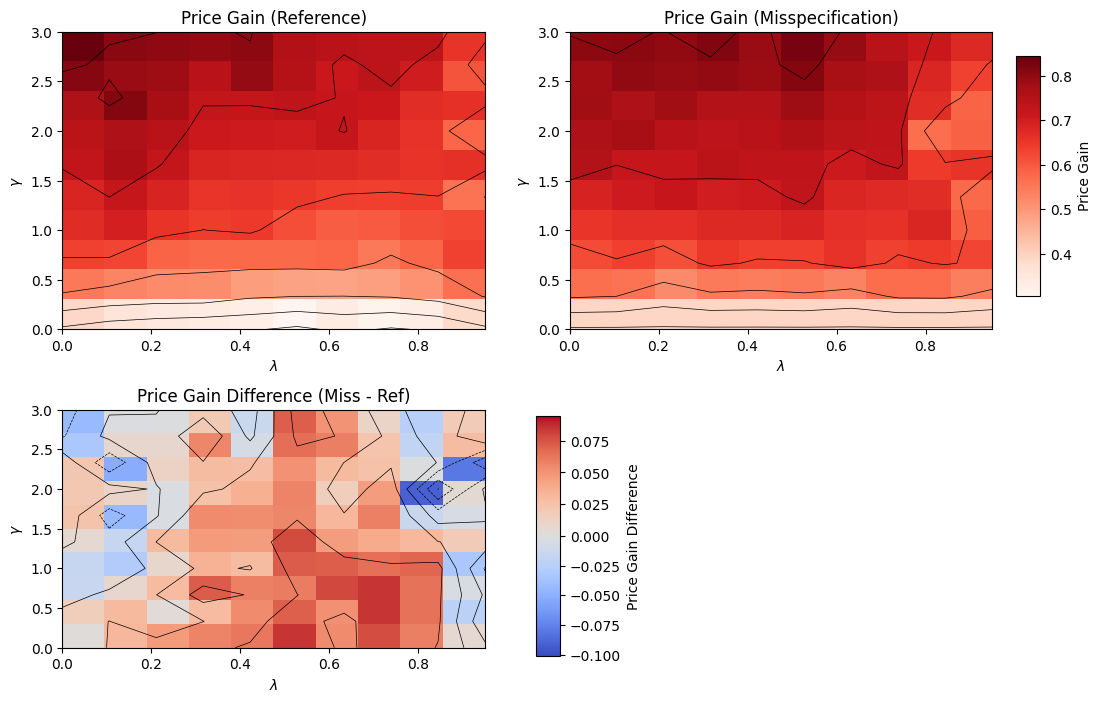

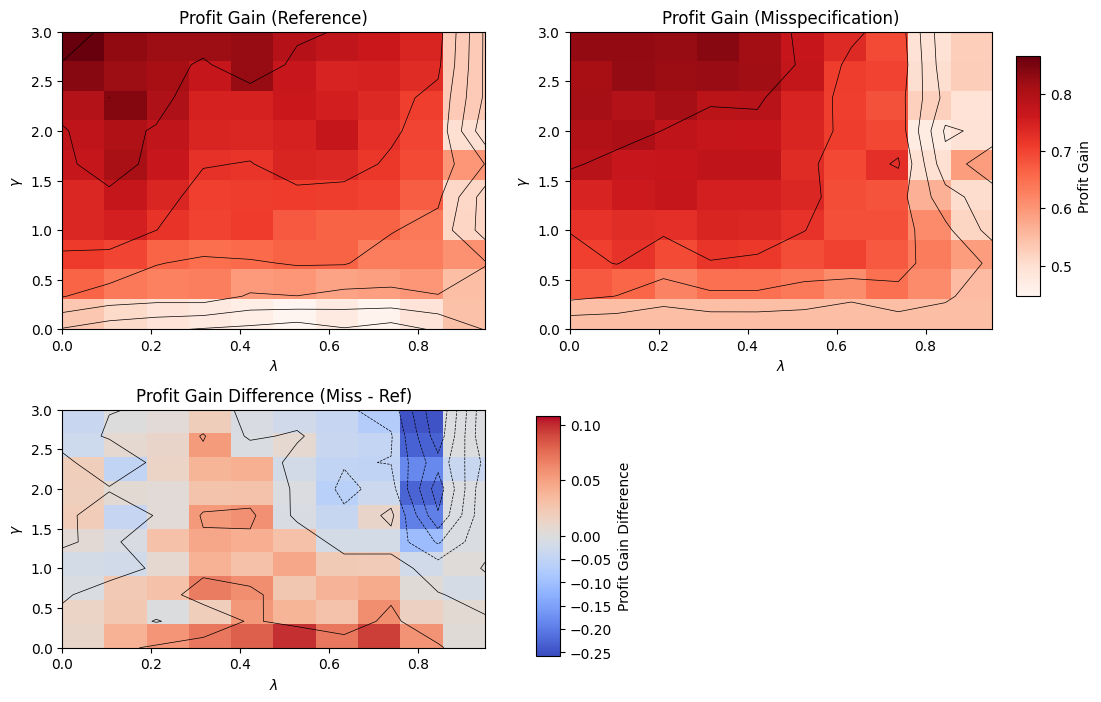

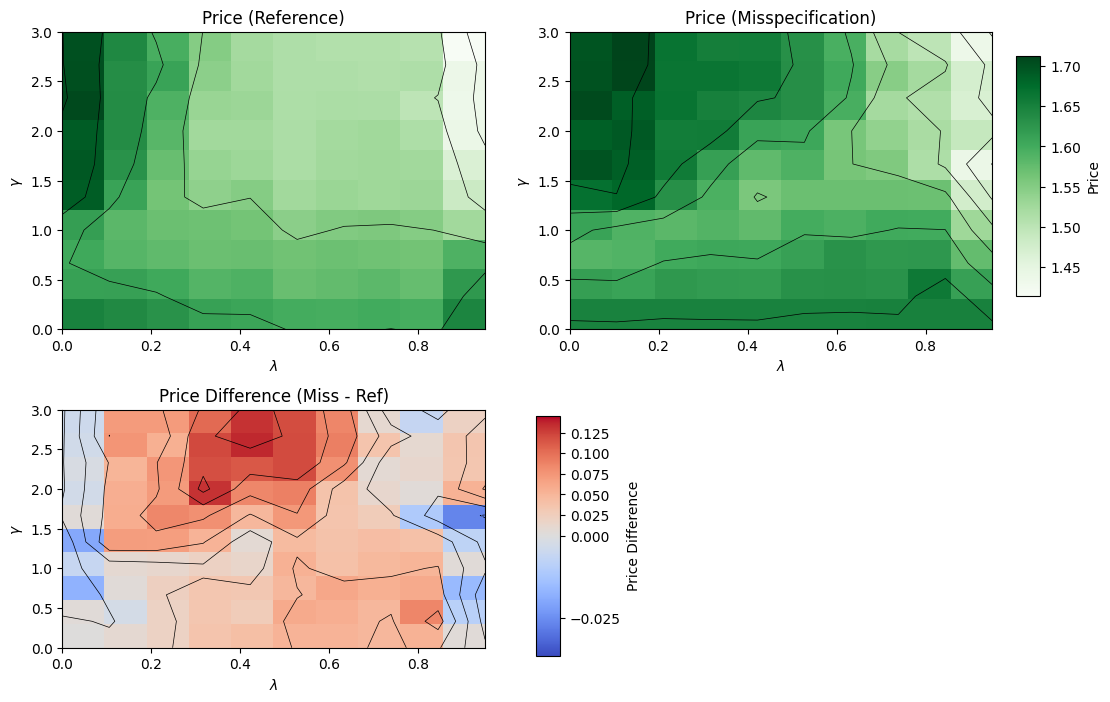

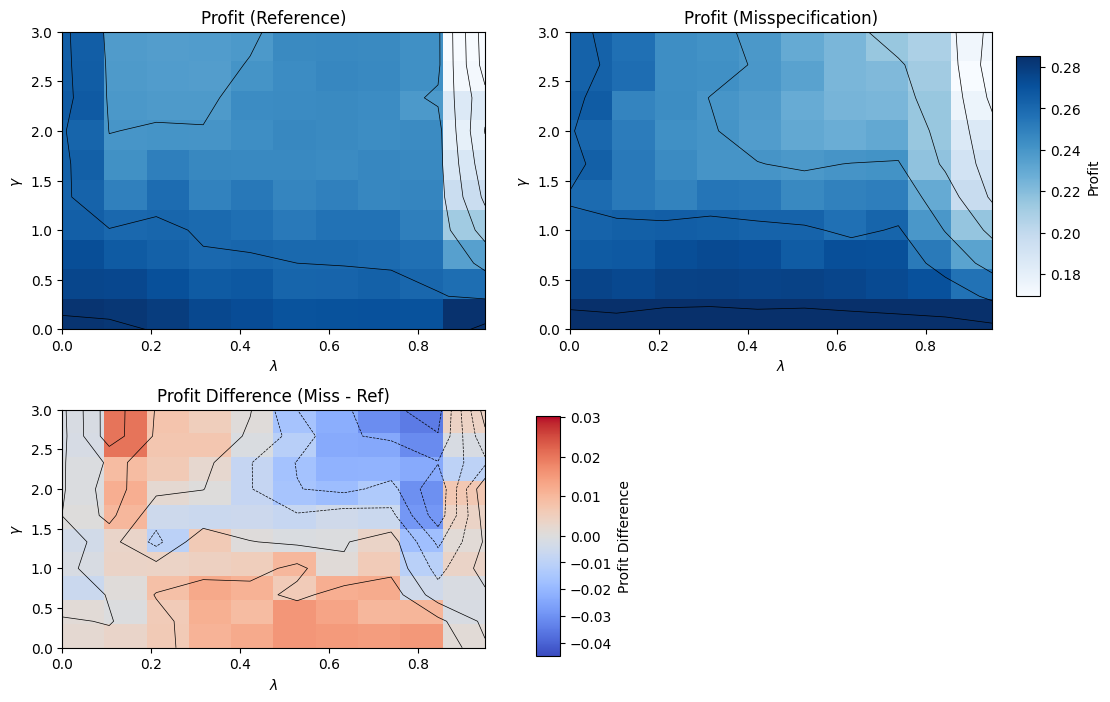

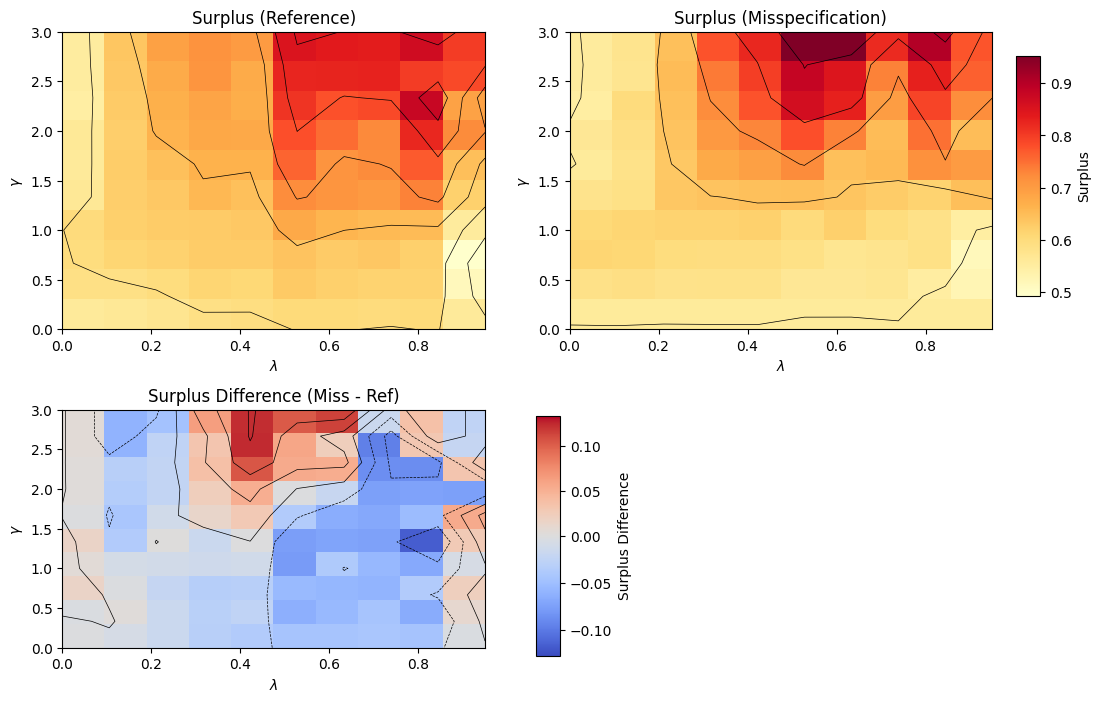

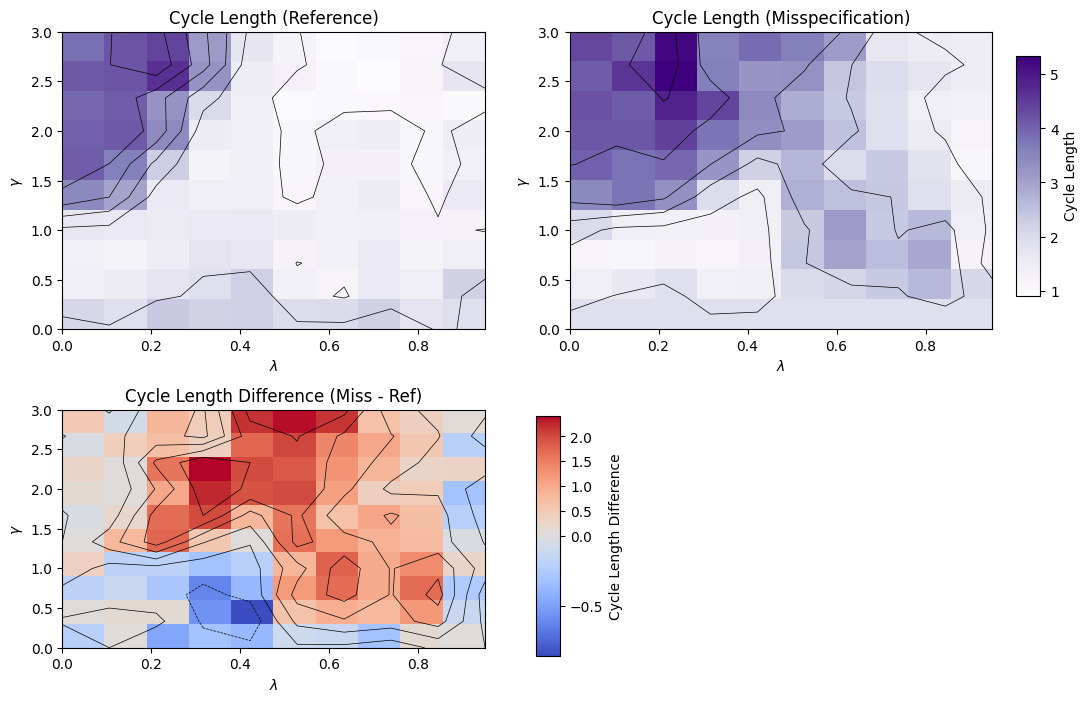

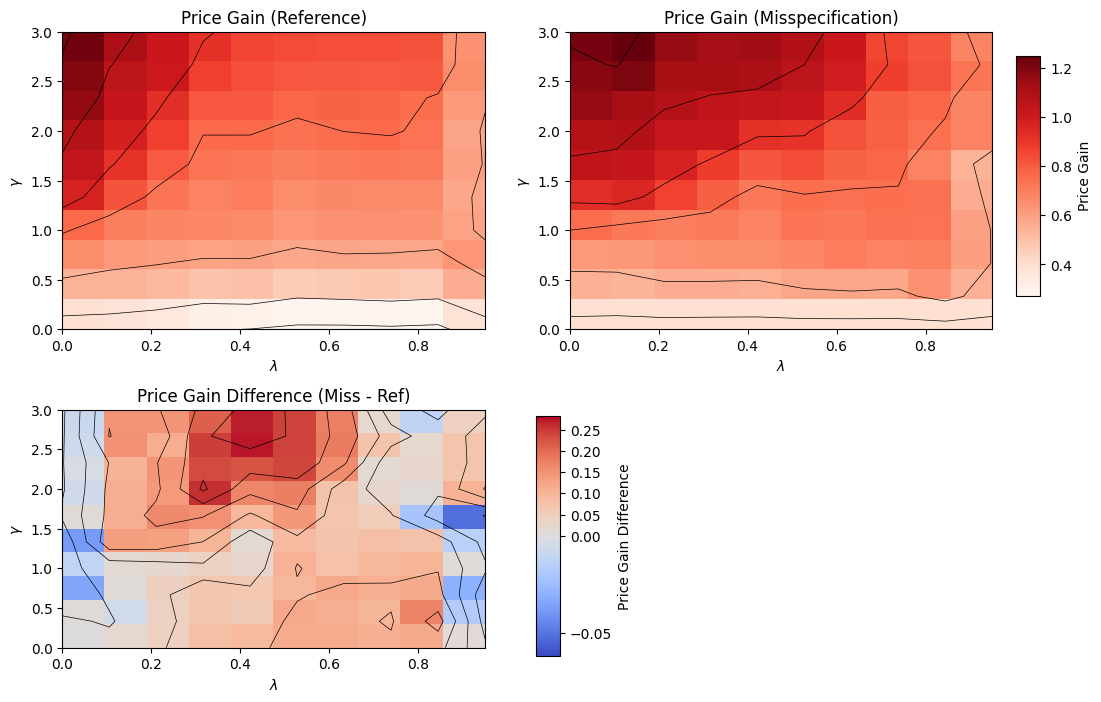

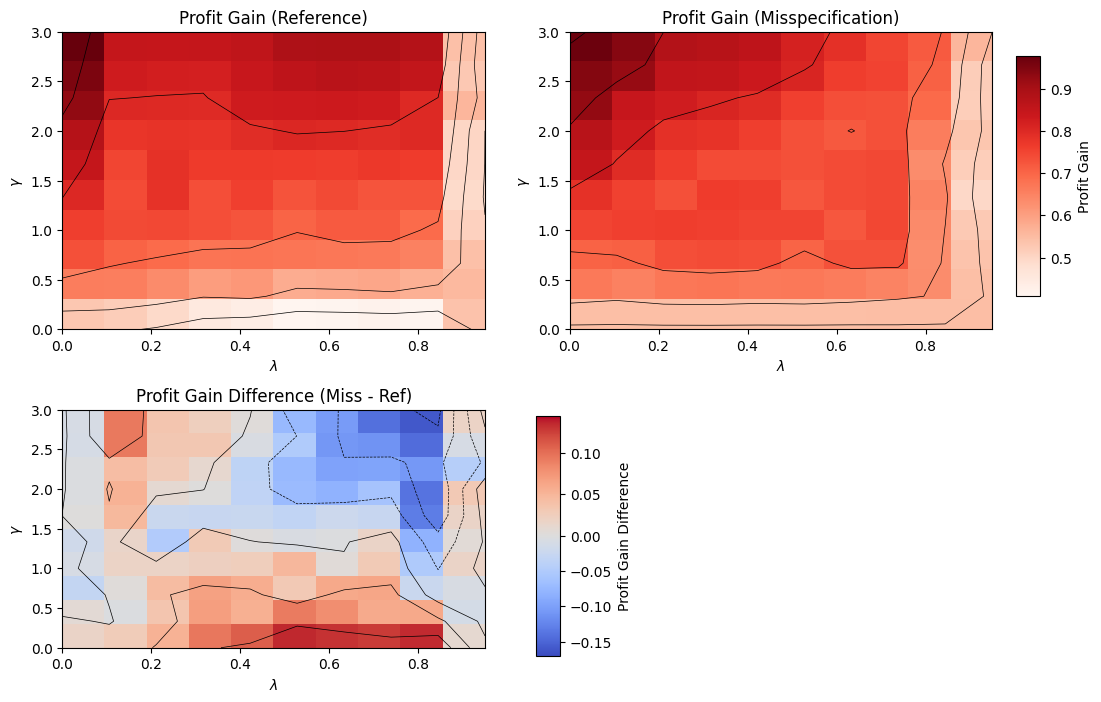

In [4]:
# 2) collect dirs by (demand_type, common_reference)
exp_dirs = {}
folder_location = "../Results_sockeye/experiments"
experiment_base = "reference_two_gamma_lambda_sockeye/gamma_lambda_c"
for demand_type in ['reference', 'misspecification']:
    for common_ref in [True, False]:
        # build a unique name
        exp_name = f"{experiment_base}_{demand_type}_{common_ref}"

        # save the path for later
        exp_dirs[(demand_type, common_ref)] = \
            os.path.join(folder_location, exp_name)

# 3) now do comparative heatmaps across common_reference for each demand_type
base_fig_dir = os.path.join(folder_location, experiment_base, "Comparative_Figures")
os.makedirs(base_fig_dir, exist_ok=True)

metrics = ["Price", "Profit", "Surplus", "Cycle Length", "Price Gain", "Profit Gain"]
#metrics = ["Price"]
for common_ref in [True, False]:
    # build the dict that create_comparative_heatmaps_gl expects:
    dirs = {
        'reference'      : exp_dirs[('reference',       common_ref)],
        'misspecification': exp_dirs[('misspecification', common_ref)]
    }

    # suffix for filenames
    suffix = "cr_true" if common_ref else "cr_false"

    for metric in metrics:
        fig = create_comparative_heatmaps_gl(
                    folder_location,
                    dirs,
                    metric_name=metric
                )
        fname = f"{metric.lower().replace(' ', '_')}_{suffix}_compare.png"
        fig.savefig(os.path.join(base_fig_dir, fname))

### 4 figures side by side

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

def create_4group_comparative_heatmaps_gl(results_dir, experiment_dirs, metric_name="Price", figsize=(20, 10)):
    """
    Creates a 2-row heatmap layout for all four groups:
    First row: Reference & Misspecification for both CR=True and CR=False
    Second row: Differences (Miss-Ref for both CR values, and CR diffs for each demand type)

    Parameters:
    -----------
    results_dir : str
        Directory containing experiment results.
    experiment_dirs : dict
        Keys should be tuples: ('reference' or 'misspecification', True or False)
    metric_name : str
        Metric to visualize.
    figsize : tuple
        Size of the entire figure.
    """
    
    # Extract all 4 groups
    data = {}
    for demand_type in ['reference', 'misspecification']:
        for cr in [True, False]:
            key = (demand_type, cr)
            gammas, lambdas, metrics = extract_metric_data_gl(experiment_dirs[key], metric_name)
            gammas, lambdas, metrics = np.array(gammas), np.array(lambdas), np.array(metrics)
            data[key] = (gammas, lambdas, metrics)

    # Calculate global vmin/vmax
    all_metrics = np.concatenate([data[key][2] for key in data])
    vmin = np.nanmin(all_metrics)
    vmax = np.nanmax(all_metrics)

    # Setup plot
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    cmap_main = 'Reds' if "Gain" in metric_name else (
                'Blues' if "Profit" in metric_name else (
                'Purples' if "Cycle Length" in metric_name else (
                'YlOrRd' if "Surplus" in metric_name else 'Greens')))
    
    heatmaps = []

    def plot_single(ax, gamma_vals, lambda_vals, metric_vals, title, cmap, norm):
        unique_gammas = np.sort(np.unique(gamma_vals))
        unique_lambdas = np.sort(np.unique(lambda_vals))
        grid = np.full((len(unique_gammas), len(unique_lambdas)), np.nan)
        for g, l, val in zip(gamma_vals, lambda_vals, metric_vals):
            i = np.where(unique_gammas == g)[0][0]
            j = np.where(unique_lambdas == l)[0][0]
            grid[i, j] = val
        # Fill NaNs
        valid = metric_vals[~np.isnan(metric_vals)]
        grid = np.nan_to_num(grid, nan=(np.nanmin(valid) if valid.size > 0 else 0))
        im = ax.imshow(grid, aspect='auto', origin='lower',
                       extent=[min(unique_lambdas), max(unique_lambdas), min(unique_gammas), max(unique_gammas)],
                       cmap=cmap, norm=norm)
        ax.set_title(title)
        ax.set_xlabel(r"$\lambda$")
        ax.set_ylabel(r"$\gamma$")
        ax.contour(grid, levels=6, colors="black", linewidths=0.5,
                   extent=[min(unique_lambdas), max(unique_lambdas), min(unique_gammas), max(unique_gammas)])
        return im

    # First row: Raw plots
    titles = [
        "Reference (CR=True)",
        "Misspecification (CR=True)",
        "Reference (CR=False)",
        "Misspecification (CR=False)"
    ]
    keys = [('reference', True), ('misspecification', True),
            ('reference', False), ('misspecification', False)]

    for i, (ax, key, title) in enumerate(zip(axes[0], keys, titles)):
        g, l, m = data[key]
        im = plot_single(ax, g, l, m, title, cmap_main, mcolors.Normalize(vmin=vmin, vmax=vmax))
        heatmaps.append(im)

    # Second row: Differences
    diffs = [
        ('misspecification', True, 'reference', True, "Miss - Ref (CR=True)"),
        ('misspecification', False, 'reference', False, "Miss - Ref (CR=False)"),
        ('reference', True, 'reference', False, "Ref (CR=True - CR=False)"),
        ('misspecification', True, 'misspecification', False, "Miss (CR=True - CR=False)")
    ]
    for i, (d1, c1, d2, c2, title) in enumerate(diffs):
        g, l, m1 = data[(d1, c1)]
        _, _, m2 = data[(d2, c2)]
        diff = m1 - m2
        vmin_d, vmax_d = min(np.nanmin(diff), 0), max(np.nanmax(diff), 0)
        im = plot_single(axes[1][i], g, l, diff, title, "coolwarm",
                         mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin_d - 0.01, vmax=vmax_d + 0.01))
        heatmaps.append(im)

    # Colorbars
    cbar_ax_main = fig.add_axes([0.92, 0.6, 0.015, 0.25])
    cbar = fig.colorbar(heatmaps[0], cax=cbar_ax_main)
    cbar.set_label(metric_name)

    cbar_ax_diff = fig.add_axes([0.92, 0.15, 0.015, 0.25])
    cbar_diff = fig.colorbar(heatmaps[4], cax=cbar_ax_diff)
    cbar_diff.set_label(f"{metric_name} Differences")

    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    return plt.gcf()


../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_False
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_False
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_False
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_misspecification_False
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_True
../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c_reference_False
../Resu

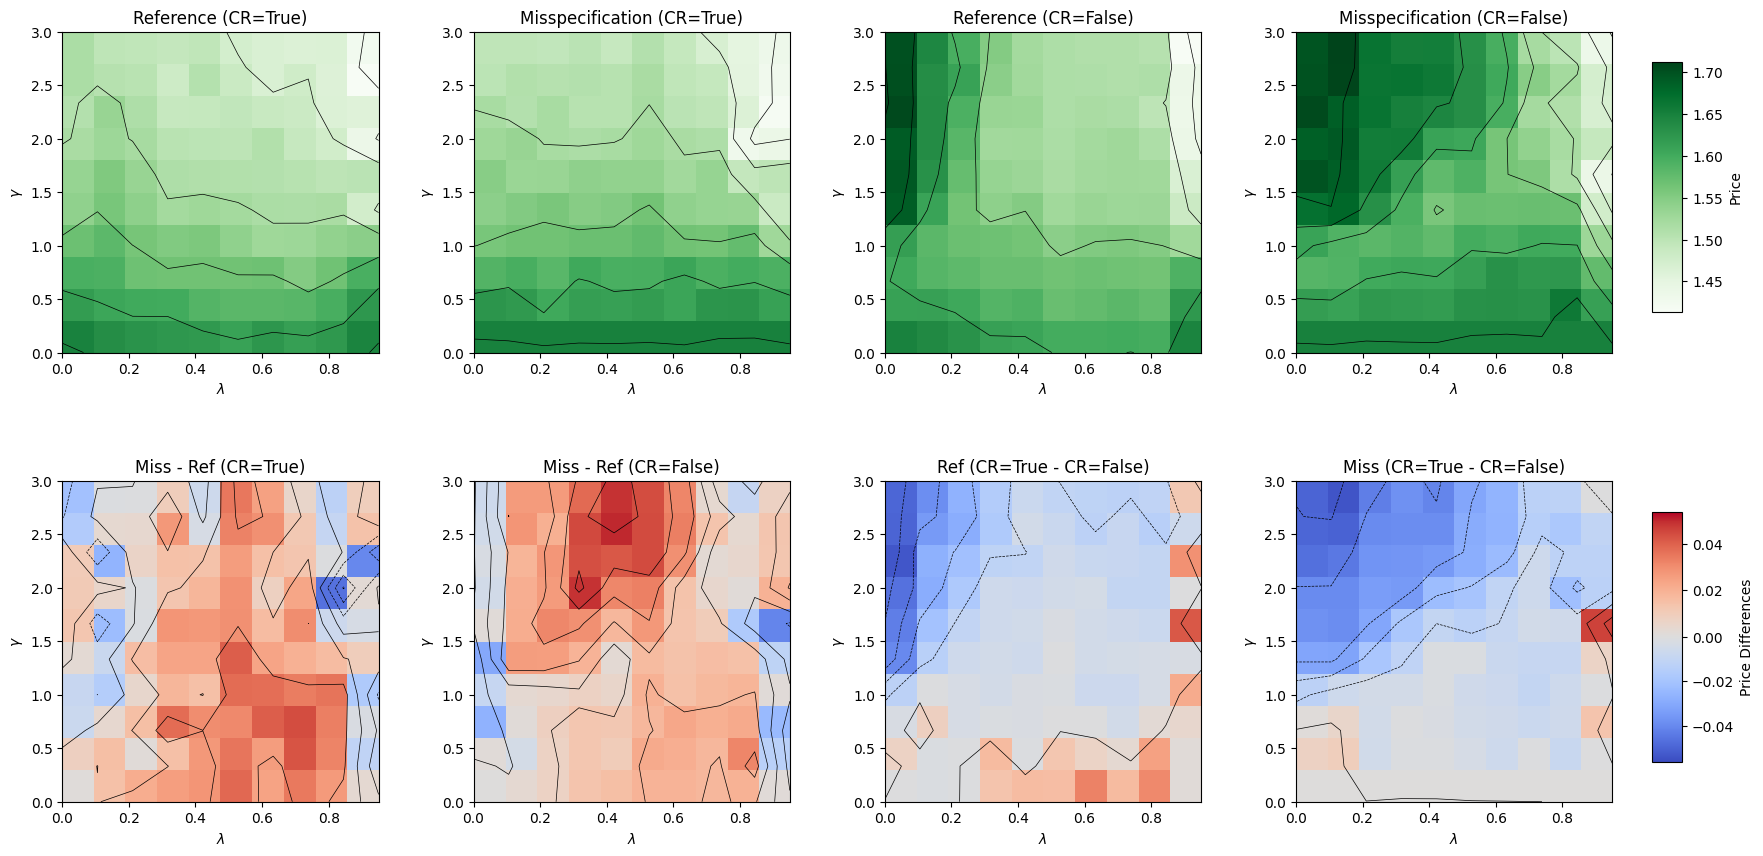

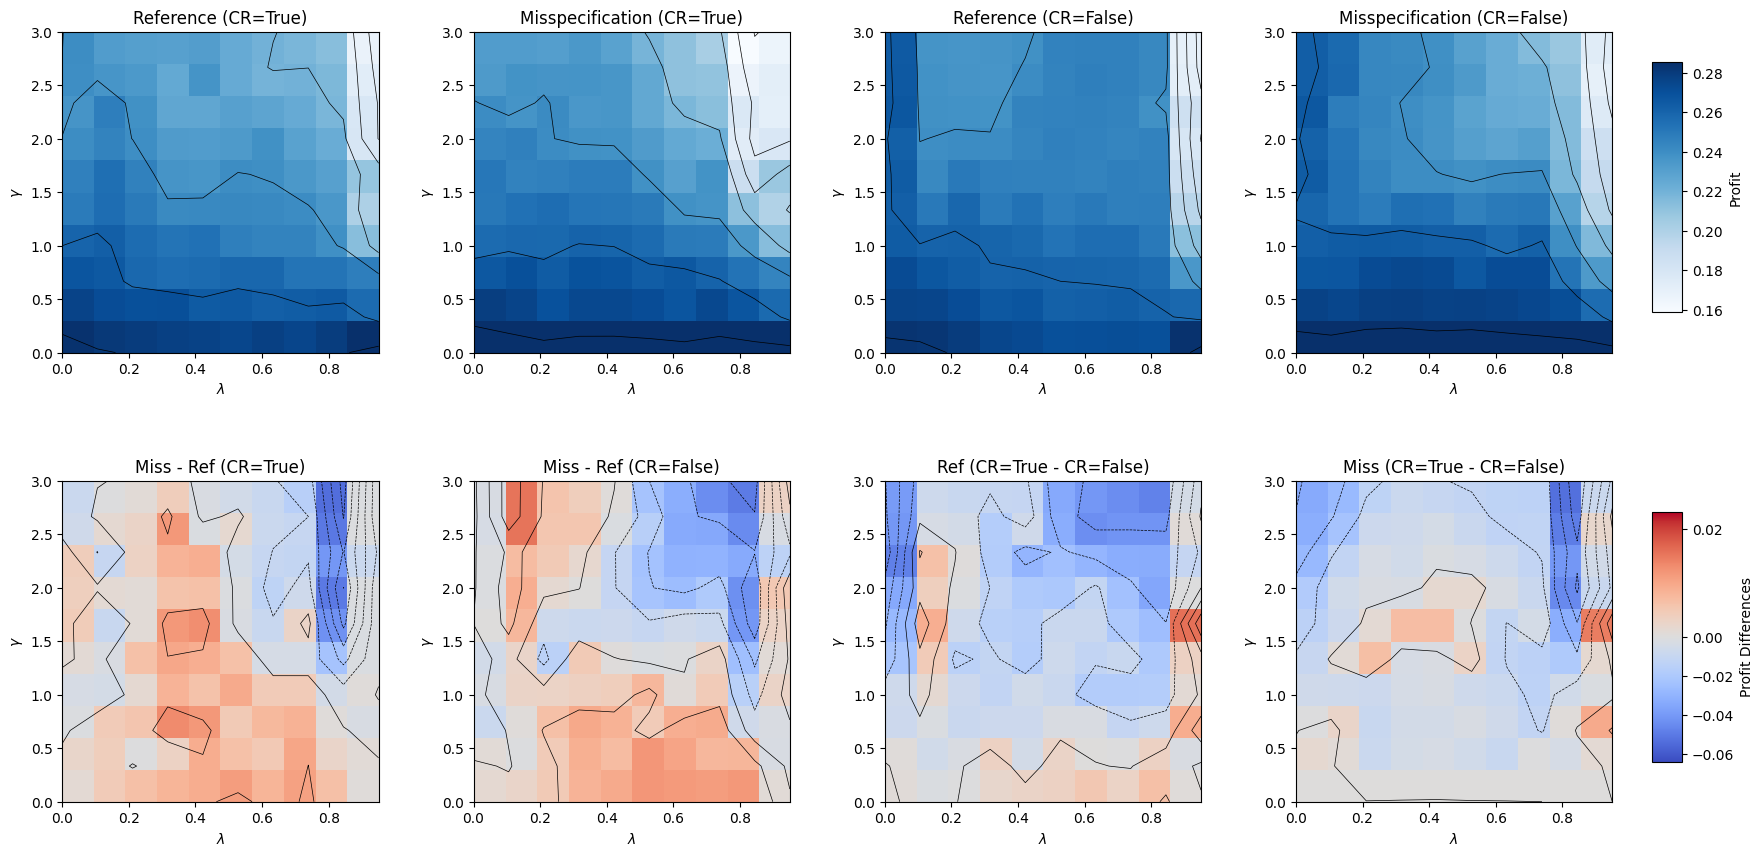

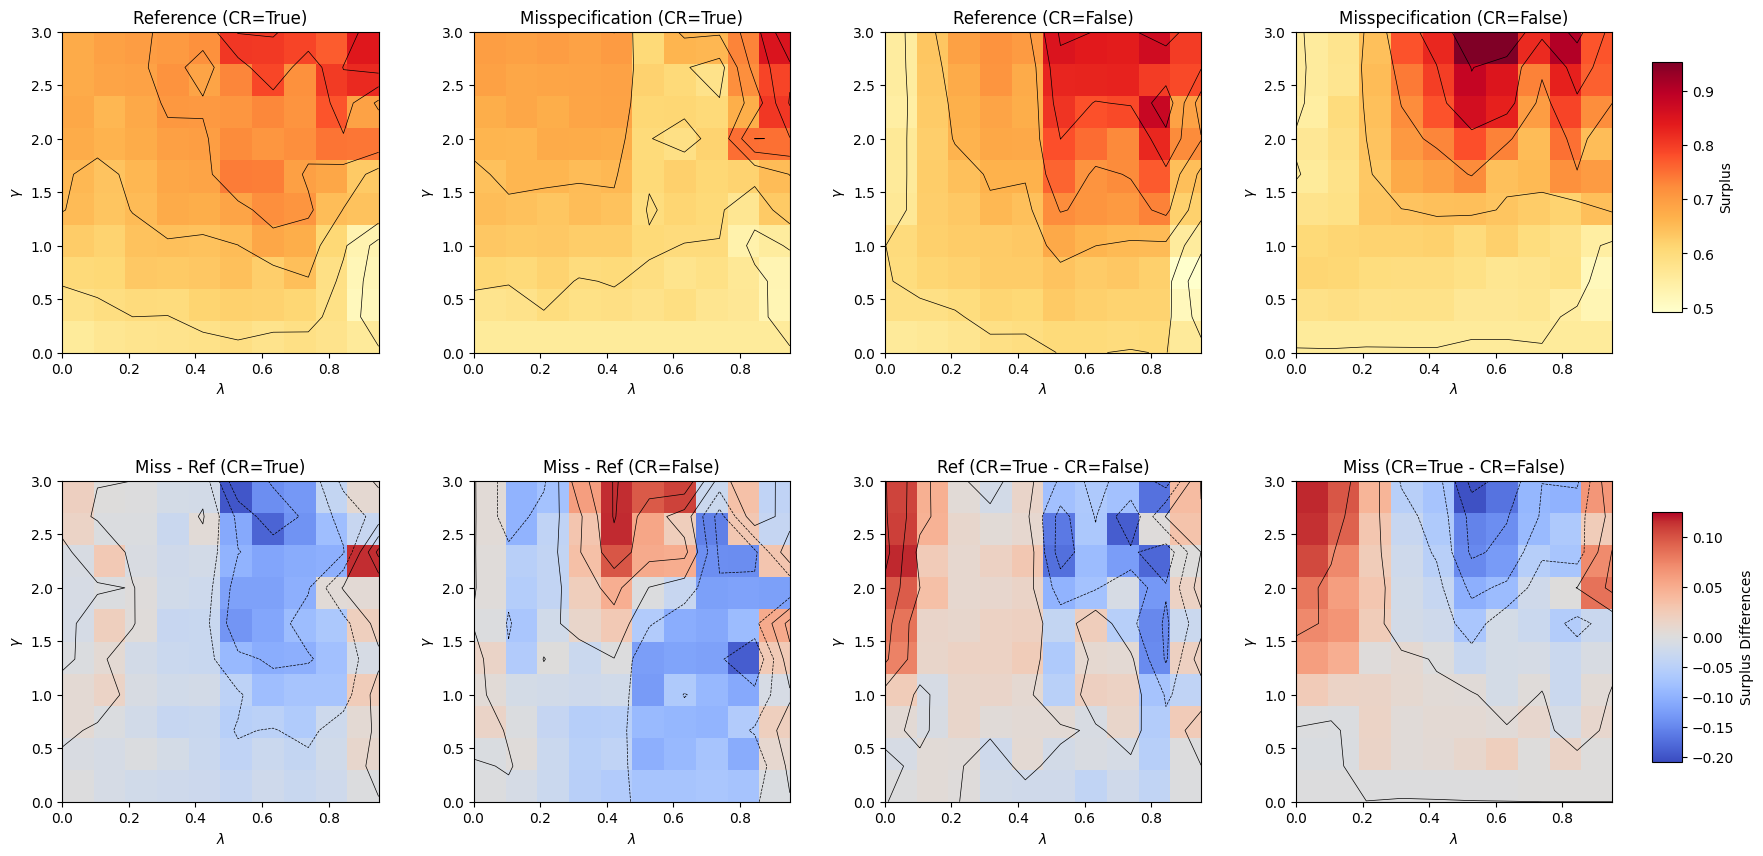

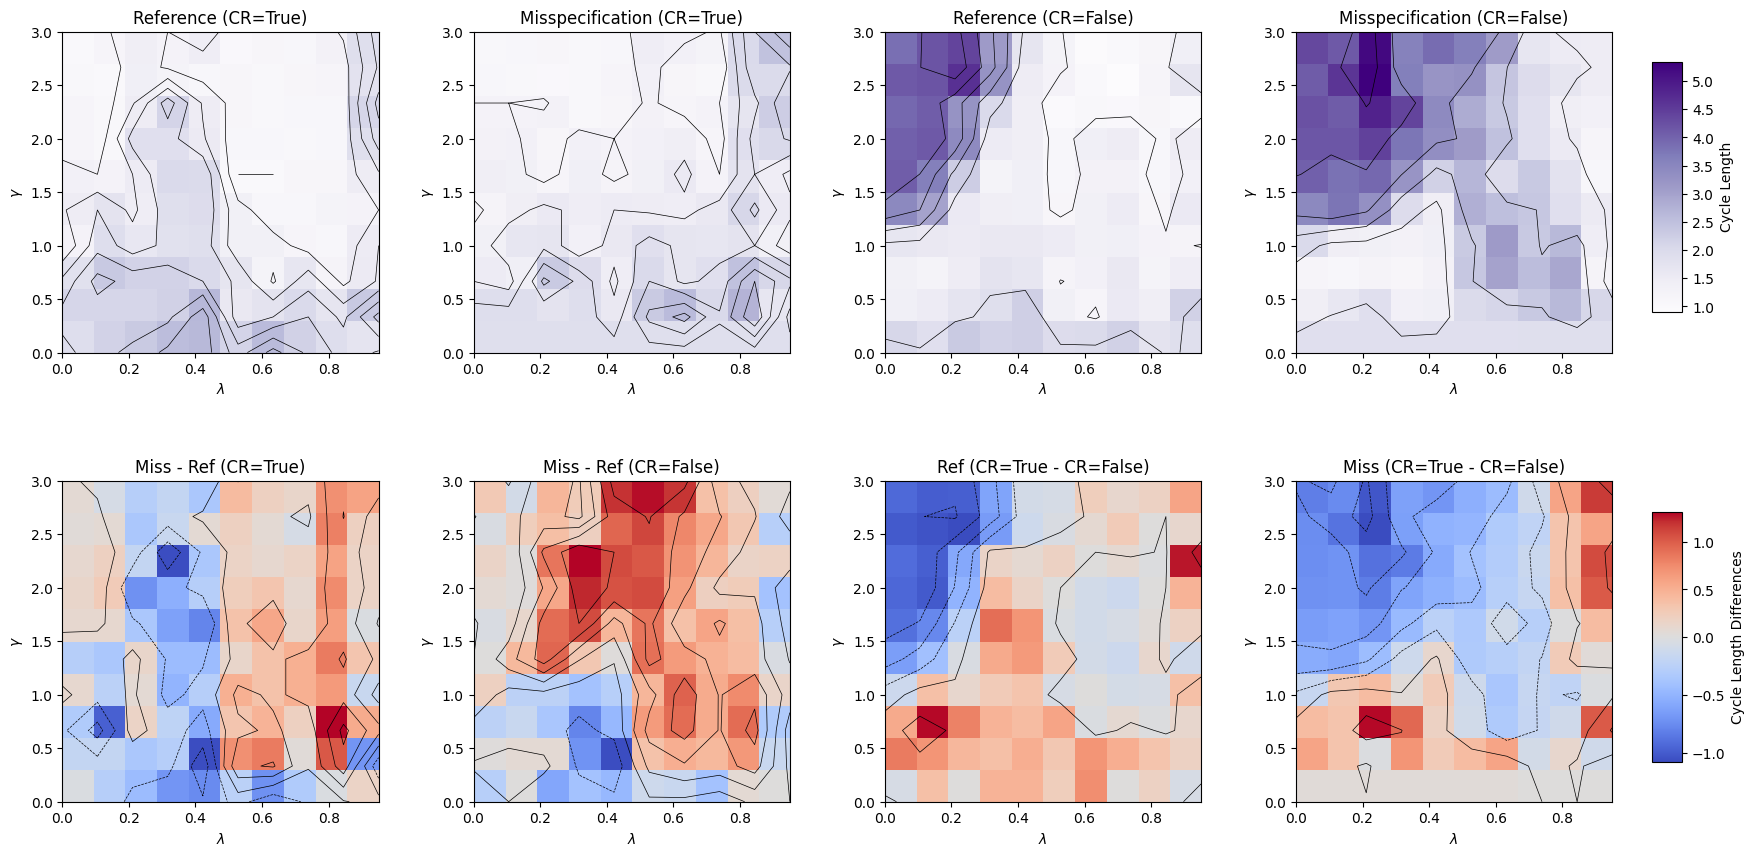

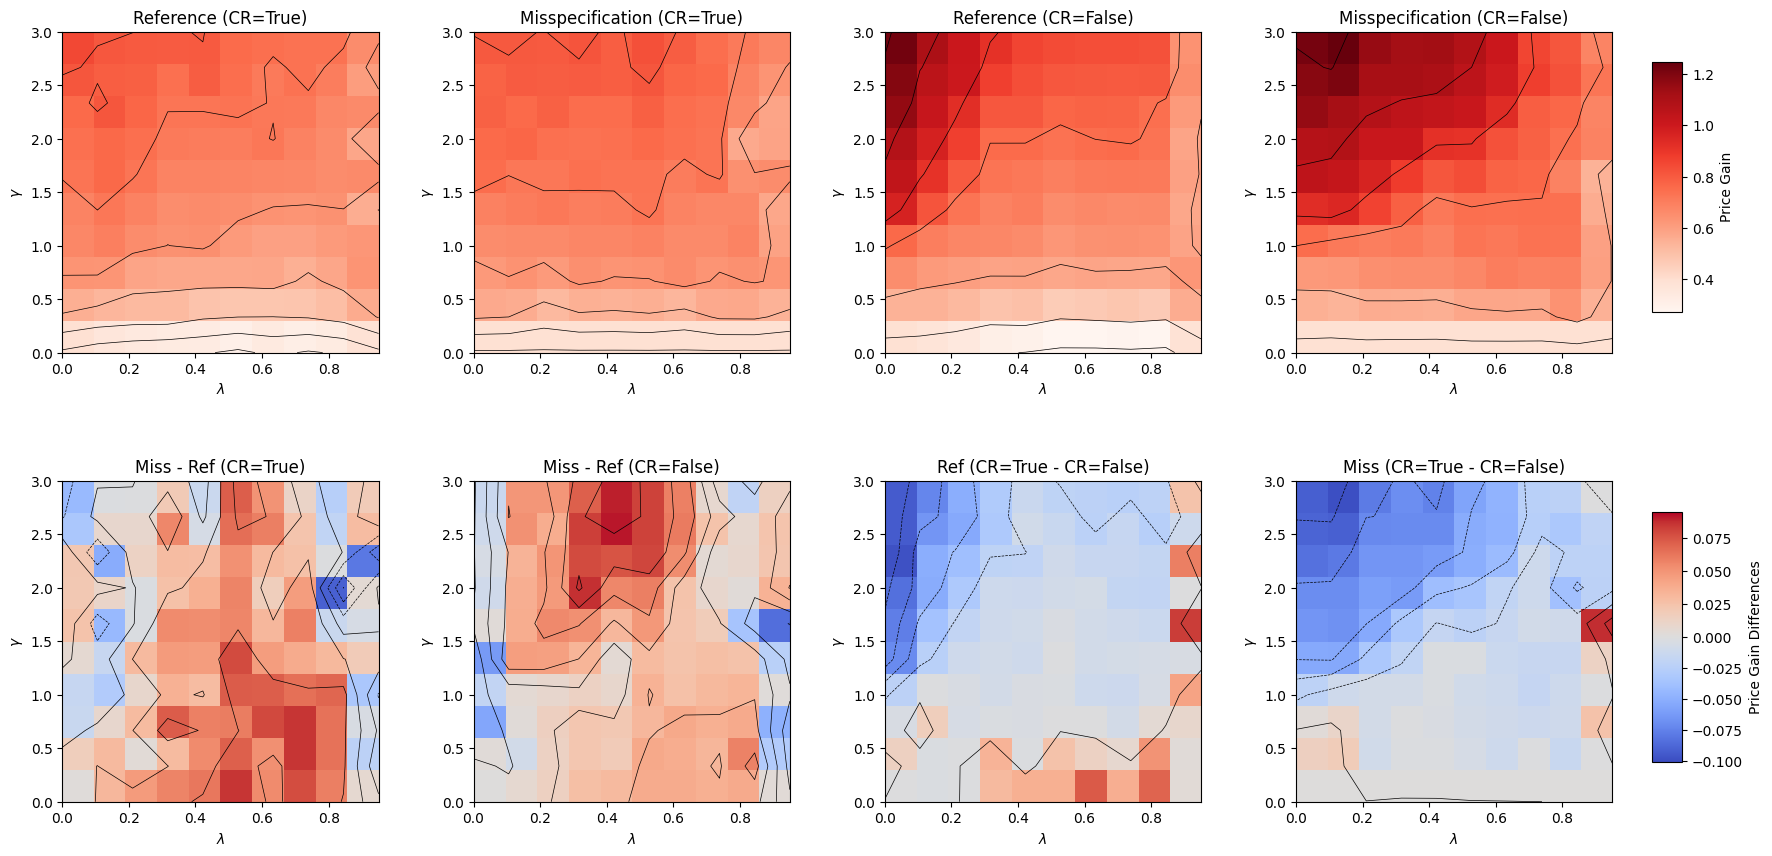

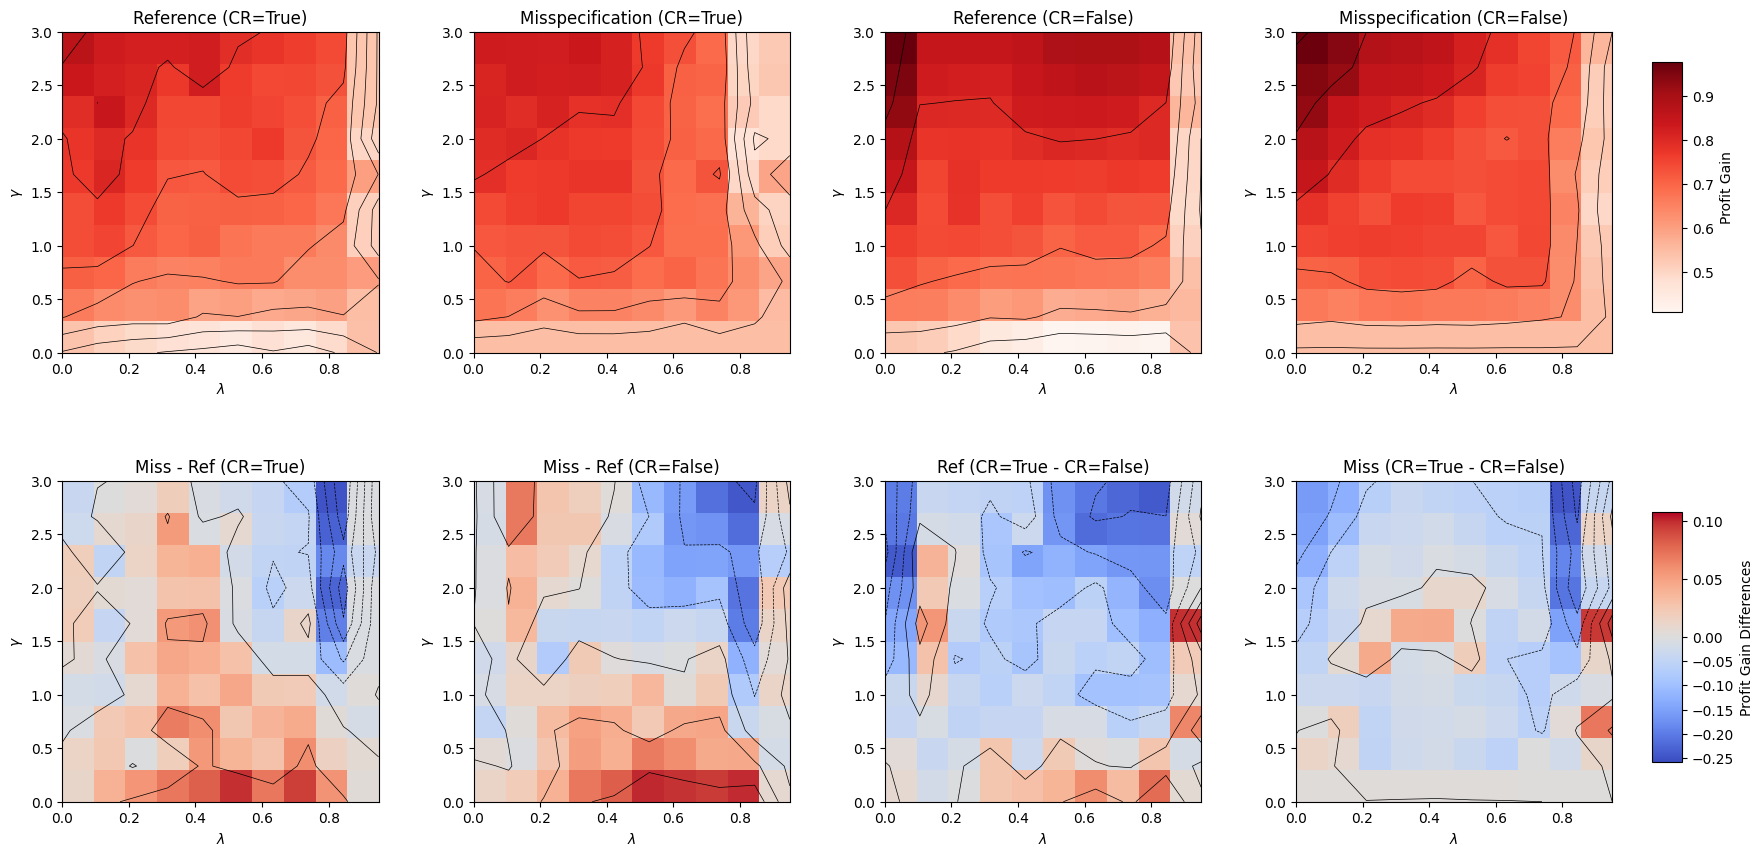

In [8]:
import os

# 1) define experiment folders
folder_location = "../Results_sockeye/experiments"
experiment_base = "reference_two_gamma_lambda_sockeye/gamma_lambda_c"

exp_dirs = {}
for demand_type in ['reference', 'misspecification']:
    for common_ref in [True, False]:
        exp_name = f"{experiment_base}_{demand_type}_{common_ref}"
        exp_dirs[(demand_type, common_ref)] = os.path.join(folder_location, exp_name)

# 2) create output directory for comparative figures
base_fig_dir = os.path.join(folder_location, experiment_base, "Comparative_Figures")
os.makedirs(base_fig_dir, exist_ok=True)

# 3) metrics to plot
metrics = ["Price", "Profit", "Surplus", "Cycle Length", "Price Gain", "Profit Gain"]

# 4) generate & save one 4-group figure per metric
for metric in metrics:
    fig = create_4group_comparative_heatmaps_gl(
        results_dir=folder_location,
        experiment_dirs=exp_dirs,
        metric_name=metric,
        figsize=(20, 10)
    )
    # sanitize filename
    fname = metric.lower().replace(" ", "_") + "_4group_compare.png"
    fig.savefig(os.path.join(base_fig_dir, fname))


***
Generating gamma only figures for all 4 groups

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# ———————————————
# helper as before
def load_gamma_metric(experiment_dir, metric_name):
    pattern = "gamma_*_lambda_*"
    run_dirs = glob(os.path.join(experiment_dir, pattern))

    gammas, values = [], []
    for run in run_dirs:
        base = os.path.basename(run)
        try:
            γ = float(base.split('gamma_')[1].split('_lambda_')[0])
        except:
            continue

        stats_file = os.path.join(run, "cycle_statistics.csv")
        if not os.path.exists(stats_file):
            continue

        df = pd.read_csv(stats_file)
        if metric_name == "Cycle Length":
            val = float(df["mean_cycle_length"].iloc[0])
        elif metric_name == "Surplus":
            val = float(df["mean_consumer_surplus"].iloc[0])
        else:
            key = metric_name.lower().replace(" ", "_")
            cols = [c for c in df.columns if c.startswith(f"mean_{key}_p")]
            val = df[cols].mean(axis=1).iloc[0] if cols else np.nan

        gammas.append(γ)
        values.append(val)

    if not gammas:
        raise ValueError(f"No data in {experiment_dir} for '{metric_name}'")

    df2 = pd.DataFrame({"gamma": gammas, "value": values}).dropna()
    grouped = df2.groupby("gamma")["value"].agg(["mean", "std"]).reset_index()
    return grouped["gamma"].values, grouped["mean"].values, grouped["std"].values

# ———————————————
# paths
folder_location = "../Results_sockeye/experiments"
experiment_base = "reference_two_gamma_lambda_sockeye/gamma_lambda_c"

exp_dirs = {
    ('reference', True)       : os.path.join(folder_location, f"{experiment_base}_reference_True"),
    ('misspecification', True): os.path.join(folder_location, f"{experiment_base}_misspecification_True"),
    ('reference', False)      : os.path.join(folder_location, f"{experiment_base}_reference_False"),
    ('misspecification', False): os.path.join(folder_location, f"{experiment_base}_misspecification_False"),
}

out_dir = os.path.join(folder_location, experiment_base, "Gamma_Figures")
os.makedirs(out_dir, exist_ok=True)

metrics = ["Price", "Profit", "Price Gain", "Profit Gain"]

# ———————————————
# plotting with improved readability
palette = plt.get_cmap("tab10")
group_defs = [
    ('reference',        True,  'Ref (CR=True)'),
    ('misspecification', True,  'Miss (CR=True)'),
    ('reference',        False, 'Ref (CR=False)'),
    ('misspecification', False, 'Miss (CR=False)'),
]
colors = [palette(i) for i in [0,1,2,3]]
markers = ['o', 's', '^', 'D']

for metric_name in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))

    for (demand, cr, label), c, m in zip(group_defs, colors, markers):
        path = exp_dirs[(demand, cr)]
        γ, μ, σ = load_gamma_metric(path, metric_name)

        ax.plot(γ, μ,
                label=label,
                color=c,
                marker=m,
                linewidth=2)
        ax.fill_between(γ, μ - σ, μ + σ,
                        color=c,
                        alpha=0.15)

    ax.set_xlabel(r"$\gamma$", fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f"{metric_name} vs γ for all 4 groups", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.5)

    # put legend outside
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout(rect=[0,0,0.85,1])  # leave space on right for legend

    fname = metric_name.lower().replace(" ", "_") + "_gamma_all4.png"
    out_path = os.path.join(out_dir, fname)
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

    print(f"Saved improved plot → {out_path}")


Saved improved plot → ../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c/Gamma_Figures/price_gamma_all4.png
Saved improved plot → ../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c/Gamma_Figures/profit_gamma_all4.png
Saved improved plot → ../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c/Gamma_Figures/price_gain_gamma_all4.png
Saved improved plot → ../Results_sockeye/experiments/reference_two_gamma_lambda_sockeye/gamma_lambda_c/Gamma_Figures/profit_gain_gamma_all4.png
